# VSG Mode - Enhanced Grid Forming

|  | Mode | Description |
| --- | --- | --- |
| 1 | "Swing" | Ideal voltage source without dynamics (i.e., an infinite bus) |
| 2 | "PQ" | Grid following controllable source/load (real and imaginary power) |
| 3 | "Droop" | Simple grid forming with power balancing through a droop mechanism |
| 4 | __"Synchronverter" or "VSG"__|  __Grid forming control mimicking a generator, i.e., virtual synchronous generator__ |

- The "VSG" mode is more enhanced form of droop allowing users to refine the behaviour of the inverter.

## Summary

- The following example is intended to introduce you to a more advanced form of decentralised control.
- The example also demonstrates a discrete Luenberger observer for when the supply's filter is "LCL".
- A supply in "VSG" mode "communicates" with other inverters in the network through the voltage and frequency.
- This mode is autonomous and provides a quantifiable measure of "inertia" to the network.

### Theory

The specific VSG mode that is available to users is the "Synchronverter" mode. The mode aims to mimic a synchronous generator, and thereby has two more coefficients, two time constants $τv$ and $τf$, which are used to calculate the virtual mass moment of inertia, $J$ and integral gain $K$. The mode provides additional flexibility over the droop mode, in that real and imaginary power set points can be provided. Unlike the PQ mode these set points are more akin to biases, because the inverter will not necessarily output these powers. For example, the real power set point will only be reached if the VSG is connected to a swing supply with a fixed frequency. 

<br>
<div>
<img src="figures/VSG_control.jpg" width="500"/>
</div>

Similar to the droop mode, if the user does not specify $D_p$ and $D_q$, then they are automatically tuned based on the converter power rating and the network's maximum allowable frequency and voltage deviations, i.e. $Δfmax$ and $ΔEmax$ 

$$
  D_p = \frac{S_{rated}}{{ω_{set}}^2 Δfmax}, \quad D_q = \frac{S_{rated}}{V_{set}*\sqrt{2}*ΔEmax},
$$

$$
  J = τf*D_p, \quad K = τv*ω_{set}*D_q.
$$

<br>
<div>
<img src="figures/VSG_mode.jpg" width="700"/>
</div>

In [1]:
using JEG;

_______________________________________________________________________________
### Network Configuration 

- Two inverters are connected to each other through a cable.
- The one inverter is placed in the familiar PQ mode, while the other is in VSG mode.
- The VSG inverter will regulate the frequency and the PQ inverter will follow along.
- If the inverter has an LCL filter then a discrete Luenberger observer can be implemented to estimate the two sets of currents through both inductor sets.
- If not provided by the user, the proportional and integral gains for the PI controllers are tuned automatically via a loop-shaping method.

In [2]:
# total run time, seconds
t_end = 0.08     

# Connectivity Matrix
CM = [ 0. 1.
        -1. 0.]     

parameters = Dict{Any, Any}(
        "source" => Any[
                        Dict{Any, Any}("pwr"    => 400e3,   # Rated appared power [VA] 
                                        "mode"  => "VSG",   # Controller mode
                                        "τv"    => 0.002,   # Time constant of the voltage loop [s] 
                                        "τf"    => 0.02,    # Time constant of the frequency loop [s]
                                        "fltr"  => "LCL",
                                        "Observer" => true) # Activating the Luenberger discrete Observer   
                        Dict{Any, Any}("pwr"    => 100e3,   
                                        "mode"  => "PQ",    
                                        "p_set" => 50e3,
                                        "q_set" => -40e3) 
                        ],
        "cable"   => Any[
                        Dict{Any, Any}("R"  => 0.1, 
                                        "L" => 0.25e-3, 
                                        "C" => 0.1e-4),
                        ],
    );

env = ElectricGridEnv(CM = CM, parameters = parameters, t_end = t_end, verbosity = 2);

agents = SetupAgents(env);

hook = Simulate(agents, env);

┌ Info: Normalization is done based on the defined parameter limits.
└ @ JEG c:\Gitlab\JEG\JuliaElectricGrid.jl\src\electric_grid_env.jl:329
┌ Info: Time simulation run time: 0.08 [s] ~> 801 steps
└ @ JEG c:\Gitlab\JEG\JuliaElectricGrid.jl\src\electric_grid_env.jl:330


┌ Info: 2 'classically' controlled sources have been initialised.
└ @ JEG c:\Gitlab\JEG\JuliaElectricGrid.jl\src\classical_control.jl:2686
┌ Info: 1 source has been set up in PQ mode.
└ @ JEG c:\Gitlab\JEG\JuliaElectricGrid.jl\src\classical_control.jl:2695
┌ Info: 1 source has been set up in Synchronverter mode.
└ @ JEG c:\Gitlab\JEG\JuliaElectricGrid.jl\src\classical_control.jl:2695
┌ Info: All 'classically' controlled sources have been automatically set up with droop coeficients, and proportional and integral gains.
└ @ JEG c:\Gitlab\JEG\JuliaElectricGrid.jl\src\classical_control.jl:2707


┌ Info: 1 source has been set up with a Luenberger discrete Observer.
└ @ JEG c:\Gitlab\JEG\JuliaElectricGrid.jl\src\classical_control.jl:2737


_______________________________________________________________________________
### Low-Level Rendering

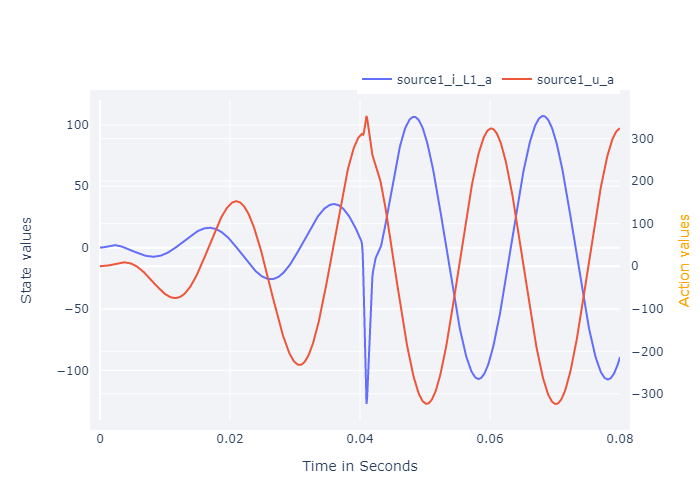

In [3]:
RenderHookResults(hook = hook, 
                    states_to_plot  = ["source1_i_L1_a"], # Inductor current [A]
                    actions_to_plot = ["source1_u_a"],    # Inverter voltage [V]
                    )

_______________________________________________________________________________
### High-Level Rendering

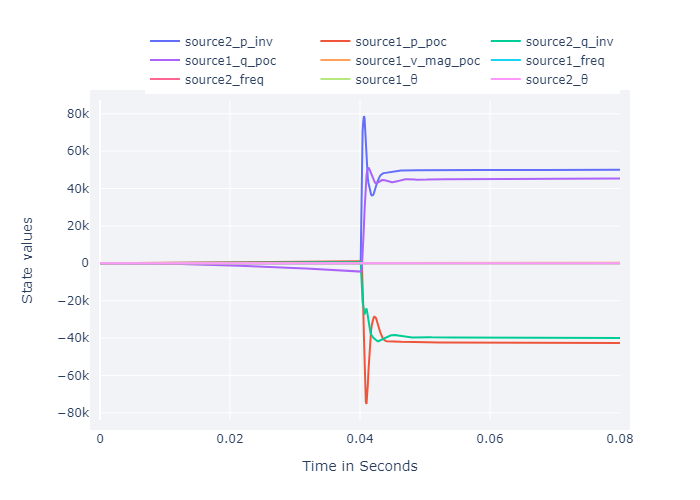

In [4]:
RenderHookResults(hook = hook, 
                    states_to_plot  = [], 
                    actions_to_plot = [],  
                    v_mag_poc       = [1],   # Scaled L₂ norm in αβγ coordinates [V]
                    power_p_inv     = [2],   # Real power [Watts]
                    power_q_inv     = [2],   # Imaginary power [VAi]
                    power_p_poc     = [1],   # Real power [Watts]
                    power_q_poc     = [1],   # Imaginary power [VAi]
                    angles          = [1 2], # Relative angle [degrees]
                    freq            = [1 2], # Angular velocity [Hz]
                    )

_______________________________________________________________________________
### Analysis

- As expected, the inverter in PQ mode behaves as it should.
- Notice that the frequency of the network is not exactly 50 Hz. This is due to the frequency droop mechanism.
- Neither does the voltage magnitude in steady state equal 230 V. This is due to the voltage droop mechanism.

_______________________________________________________________________________
### References

- Q. -C. Zhong and G. Weiss, "Synchronverters: Inverters That Mimic Synchronous Generators," in IEEE Transactions on Industrial Electronics, vol. 58, no. 4, pp. 1259-1267, April 2011, doi: 10.1109/TIE.2010.2048839.
- Q. -C. Zhong, P. -L. Nguyen, Z. Ma and W. Sheng, "Self-Synchronized Synchronverters: Inverters Without a Dedicated Synchronization Unit," in IEEE Transactions on Power Electronics, vol. 29, no. 2, pp. 617-630, Feb. 2014, doi: 10.1109/TPEL.2013.2258684.